In [2]:
import pandas as pd

dec_train_test = pd.read_csv('../DATASET/train_test/dec_train_test.csv')
nov_train_test = pd.read_csv('../DATASET/train_test/nov_train_test.csv')
oct_train_test = pd.read_csv('../DATASET/train_test/oct_train_test.csv')

C:\Users\DataScience\AppData\Local\Temp\ipykernel_61080\1214849849.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
dec_train_test

,lat,lon,year,month,precip_est,precip_obs,bias_dec,is_train
0,45.0,-20.0,1982,1,114.242190,158.107760,-43.865570,True
1,45.0,-19.0,1982,1,109.765625,138.565060,-28.799435,True
2,45.0,-18.0,1982,1,106.218750,122.867584,-16.648834,True
3,45.0,-17.0,1982,1,105.335940,109.741210,-4.405270,True
4,45.0,-16.0,1982,1,103.375000,106.399536,-3.024536,True
...,...,...,...,...,...,...,...,...
230251,20.0,16.0,2017,6,0.351885,3.776550,-3.424665,False
230252,20.0,17.0,2017,6,0.426104,3.719330,-3.293226,False
230253,20.0,18.0,2017,6,1.090166,3.147125,-2.056959,False
230254,20.0,19.0,2017,6,1.437823,0.000000,1.437823,False


In [4]:
dec_train_test = dec_train_test.drop(columns=['year'])
nov_train_test = nov_train_test.drop(columns=['year'])
oct_train_test = oct_train_test.drop(columns=['year'])

In [5]:
dec_average= dec_train_test.groupby(['month', 'is_train', 'lat', 'lon']).agg({'precip_est': 'mean', 'precip_obs': 'mean'}).reset_index()
oct_average= oct_train_test.groupby(['month', 'is_train', 'lat', 'lon']).agg({'precip_est': 'mean', 'precip_obs': 'mean'}).reset_index()
nov_average= nov_train_test.groupby(['month', 'is_train', 'lat', 'lon']).agg({'precip_est': 'mean', 'precip_obs': 'mean'}).reset_index()

In [6]:
dec_average

,month,is_train,lat,lon,precip_est,precip_obs
0,1,False,20.0,-20.0,1.605918,0.705719
1,1,False,20.0,-19.0,1.319785,0.345230
2,1,False,20.0,-18.0,0.968711,0.351906
3,1,False,20.0,-17.0,0.852500,0.422478
4,1,False,20.0,-16.0,0.831992,0.207424
...,...,...,...,...,...,...
12787,6,True,45.0,16.0,109.268251,88.549069
12788,6,True,45.0,17.0,98.144296,85.424696
12789,6,True,45.0,18.0,90.160480,76.732772
12790,6,True,45.0,19.0,82.363117,67.252568


In [23]:
# import numpy as np
# import pandas as pd

# # Your function definition remains the same
# def eQM_porcentual_delta(ref, est):
#     corrections = (ref - est) / est
#     corrected_est = est * (1 + corrections)
#     return corrected_est

In [24]:
# import pandas as pd
# import pandas as pd
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# def apply_correction_factors(df):
#     correction_factors = {}
#     # Calculate correction factors
#     for month in sorted(df['month'].unique()):
#         month_data = df[df['month'] == month]
#         training_data = month_data[month_data['is_train']]
#         if not training_data.empty:
#             corrections = (training_data['precip_obs'] - training_data['precip_est']) / training_data['precip_est']
#             correction_factors[month] = 1 + corrections.mean()
    
#     # Apply correction factors
#     corrected_precip_est = []
#     for month in sorted(df['month'].unique()):
#         month_data = df[df['month'] == month]
#         if month in correction_factors:
#             corrected_est = month_data['precip_est'] * correction_factors[month]
#             corrected_precip_est.extend(corrected_est.values)
#         else:
#             corrected_precip_est.extend(month_data['precip_est'].values)
    
#     df['corrected_precip_est'] = corrected_precip_est
#     df['RMSE'] = [sqrt(mean_squared_error([row["corrected_precip_est"]], [row["precip_obs"]])) for _, row in df.iterrows()]


# # Assuming dec_average, nov_average, oct_average are your DataFrames
# apply_correction_factors(dec_average)
# apply_correction_factors(nov_average)
# apply_correction_factors(oct_average)

# nov_average = pd.concat([nov_average[-2:], nov_average[:-2]]).reset_index(drop=True)
# oct_average = pd.concat([oct_average[-4:], oct_average[:-4]]).reset_index(drop=True)

In [7]:
import pandas as pd
import numpy as np

def apply_quantile_mapping(df):
    # Initialize a new column for the corrected estimates
    df['corrected_precip_est'] = df['precip_est']
    
    # Group by month, latitude, and longitude
    group_cols = ['month', 'lat', 'lon']
    for name, group in df.groupby(group_cols):
        training_data = group[group['is_train']]
        
        if not training_data.empty:
            # Calculate quantiles
            quantiles = np.linspace(0, 1, 100)
            obs_quantiles = np.quantile(training_data['precip_obs'], quantiles)
            est_quantiles = np.quantile(training_data['precip_est'], quantiles)

            # Create a function to map estimated values to observed quantiles
            def map_quantiles(est_value):
                idx = np.searchsorted(est_quantiles, est_value, side="right") - 1
                idx = max(0, min(idx, len(obs_quantiles) - 1))  # Ensure index is within bounds
                return obs_quantiles[idx]
            
            # Apply quantile mapping to all estimated precipitation values for this group
            correction_indices = df.index[(df['month'] == name[0]) & (df['lat'] == name[1]) & (df['lon'] == name[2])]
            df.loc[correction_indices, 'corrected_precip_est'] = group['precip_est'].apply(map_quantiles)

    # Calculate the row-wise RMSE (which will be the absolute difference here)
    df['RMSE'] = np.sqrt((df['corrected_precip_est'] - df['precip_obs'])**2)

# Example of how to use the function
# Assuming you have loaded your dataset into a DataFrame named `dataframe`
apply_quantile_mapping(dec_average)

# Display the DataFrame to check new columns
dec_average[['month', 'lat', 'lon', 'is_train', 'precip_est', 'precip_obs', 'corrected_precip_est', 'RMSE']]

,month,lat,lon,is_train,precip_est,precip_obs,corrected_precip_est,RMSE
0,1,20.0,-20.0,False,1.605918,0.705719,2.957889,2.252170
1,1,20.0,-19.0,False,1.319785,0.345230,3.697940,3.352710
2,1,20.0,-18.0,False,0.968711,0.351906,2.920423,2.568517
3,1,20.0,-17.0,False,0.852500,0.422478,3.280776,2.858298
4,1,20.0,-16.0,False,0.831992,0.207424,4.537310,4.329886
...,...,...,...,...,...,...,...,...
12787,6,45.0,16.0,True,109.268251,88.549069,88.549069,0.000000
12788,6,45.0,17.0,True,98.144296,85.424696,85.424696,0.000000
12789,6,45.0,18.0,True,90.160480,76.732772,76.732772,0.000000
12790,6,45.0,19.0,True,82.363117,67.252568,67.252568,0.000000


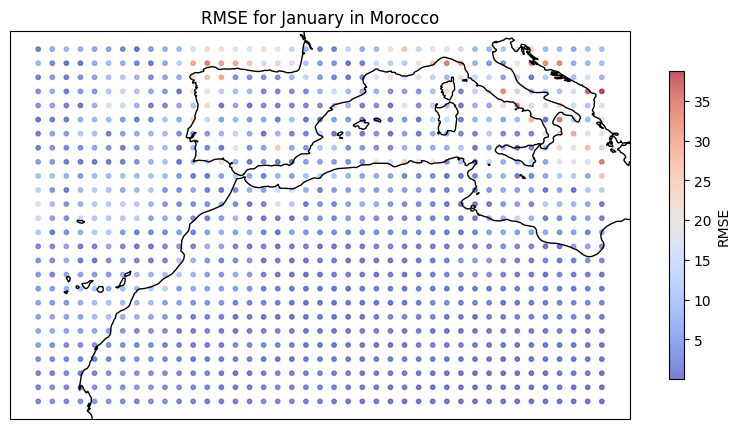

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import seaborn as sns

# Load your data into a DataFrame.
df = dec_average

# Filter the DataFrame for January and is_train == False.
january_test_df = df[(df['month'] == 1) & (df['is_train'] == False)]

# Create a scatter plot using plt.scatter for the lat/lon with the color intensity based on the RMSE.
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# You might want to adjust the extent to frame Morocco properly
# ax.set_extent([left_longitude, right_longitude, bottom_latitude, top_latitude])

scatter = ax.scatter(january_test_df['lon'], january_test_df['lat'], 
                     c=january_test_df['RMSE'], cmap='coolwarm', 
                     s=10, alpha=0.7, transform=ccrs.PlateCarree())

plt.colorbar(scatter, shrink=0.5, label='RMSE')
plt.title('RMSE for January in Morocco')
plt.show()

In [25]:
dec_average

,month,is_train,precip_est,precip_obs,corrected_precip_est,RMSE
0,1,False,36.069351,32.960211,30.428443,2.531768e+00
1,1,True,41.878524,35.329116,35.329116,0.000000e+00
2,2,False,35.391791,23.658047,26.172479,2.514432e+00
3,2,True,37.208368,27.515851,27.515851,0.000000e+00
4,3,False,32.474639,29.645861,27.930473,1.715388e+00
5,3,True,32.417786,27.881575,27.881575,3.552714e-15
6,4,False,29.426884,21.934248,21.378437,5.558108e-01
7,4,True,29.359863,21.329747,21.329747,3.552714e-15
8,5,False,24.523373,11.646328,14.480778,2.834449e+00
9,5,True,24.555590,14.499801,14.499801,1.776357e-15


In [28]:
# # Corrected code
# # For oct_average DataFrame
# RMSE_bias_oct = oct_average.drop(columns=['month', 'precip_est', 'precip_obs', 'corrected_precip_est', 'is_train']) \
#                             .loc[oct_average['is_train'] == False]

# # For nov_average DataFrame
# RMSE_bias_nov = nov_average.drop(columns=['month', 'precip_est', 'precip_obs', 'corrected_precip_est', 'is_train']) \
#                             .loc[nov_average['is_train'] == False]

# # For dec_average DataFrame
# RMSE_bias_dec = dec_average.drop(columns=['precip_est', 'precip_obs', 'corrected_precip_est', 'is_train']) \
#                             .loc[dec_average['is_train'] == False]


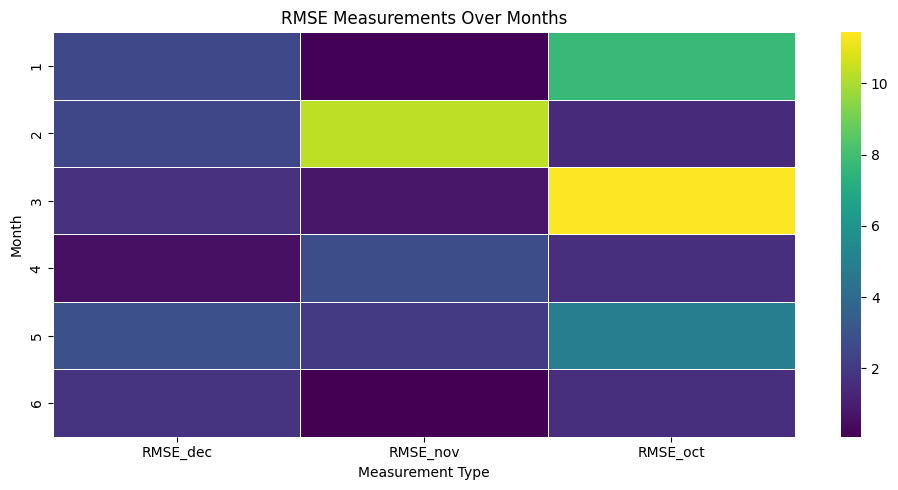

In [34]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming 'df' is your DataFrame
# # Your actual DataFrame loading or preparation code here
# df = RMSE_bias_eQM

# df.set_index('month', inplace=True)

# # Creating the heatmap
# plt.figure(figsize=(10, 5))  # Adjust the figure size as necessary
# # sns.heatmap(df, annot=True, fmt=".2f", cmap='viridis', linewidths=.5)
# sns.heatmap(df, cmap='viridis', linewidths=.5)

# plt.title('RMSE Measurements Over Months')
# plt.xlabel('Measurement Type')
# plt.ylabel('Month')
# plt.tight_layout()